# Weighting, Matching, or Regression?

*Understanding and comparing different methods for conditional causal inference analysis*

INTRO

## Example

Assume we had blog on statistics and causal inference. To improve user experience, we are considering **releasing a dark mode**, and we would like to understand whether this new feature increases the time users spend on our blog. 

<img src="fig/modes.png" width="600px"/>

We are not a sophisticated company, therefore we do not run an AB test but we simply release the dark mode and we observe whether users select it or not and the time they spend on the blog. We know that there might be **selection**:  users that prefer the dark mode could have different reading preferences and this might complicate our causal analysis.

We can represent the data generating process with the following [**Directed Acyclic Graph (DAG)**](https://towardsdatascience.com/b63dc69e3d8c).

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X2 --> Y
X3 --> D
X3 --> Y

class D,Y included;
class X1,X2,X3 excluded;
```

We generate the simulated data using the data generating process `dgp_darkmode()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py).

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *
from src.dgp import dgp_darkmode

In [3]:
df = dgp_darkmode().generate_data()
df.head()

,read_time,dark_mode,male,age,hours
0,10.42,False,0,43.0,79.17
1,11.41,True,1,55.0,130.35
2,20.88,False,0,23.0,458.21
3,17.02,False,0,41.0,133.30
4,21.04,True,0,29.0,179.65


We have informations on 300 users for whom we observe whether they select the `dark_mode` (the treatment), their weekly `read_time` (the outcome of interest) and some characteristics like `gender`, `age` and total `hours` previously spend on the blog.

We would like to estimate the effect of the new `dark_mode` on users' `read_time`. If we were runnig an [**AB test**](https://de.wikipedia.org/wiki/A/B-Test) or randomized control trial, we could just compare users with and without the dark mode and we could attribute the difference in average reading time to the `dark_mode`. Let's check what number we would get.

In [4]:
np.mean(df.loc[df.dark_mode==True, 'read_time']) - np.mean(df.loc[df.dark_mode==False, 'read_time'])

-1.3702904153929154

Individuals that select the `dark_mode` spend on average 1.37 hours less on the blog, per week. Should we conclude that `dark_mode` is a **bad idea**? Is this a causal effect?

We did not randomize the `dark_mode` so that users that selected it might not be directly **comparable** with users that don't. Can we check this concern? Partially. We can only check it for characteristics that we observe, `gender`, `age` and total `hours` in our setting. We cannot check if users differ along other dimensions that we don't observe.

Let's use the `create_table_one` function from Uber's [`causalml`](https://causalml.readthedocs.io/) package to produce a **covariate balance table**, containing the average value of our observable characteristics, across treatment and control groups. As the name suggests, this should always be the first table you present in causal inference analysis.

In [5]:
from causalml.match import create_table_one

X = ['male', 'age', 'hours']
table1 = create_table_one(df, 'dark_mode', X)
table1

,Control,Treatment,SMD
Variable,,,
n,166,134,
age,41.33 (11.60),44.13 (10.57),0.2524
hours,303.91 (330.20),205.16 (279.63),-0.3228
male,0.37 (0.48),0.66 (0.48),0.6025


There seems to be **some difference** between treatment (`dark_mode`) and control group. In particular, users that select the `dark_mode` are older, have spend less hours on the blog and they are more likely to be males.

Another way to visually observe all the differences at once is with a **paired violinplot**. The advantage of the paired violinplot is that it allows us to observe the full distribution of the variable (approximated via [kernel density estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation)).

In [6]:
def plot_distributions(df, X, d):
    df_long = df.copy()[X + [d]]
    df_long[X] =(df_long[X] - df_long[X].mean()) / df_long[X].std()
    df_long = pd.melt(df_long, id_vars=d, value_name='value')
    sns.violinplot(y="variable", x="value", hue=d, data=df_long, split=True).\
        set(xlabel="", ylabel="", title="Normalized Variable Distribution");

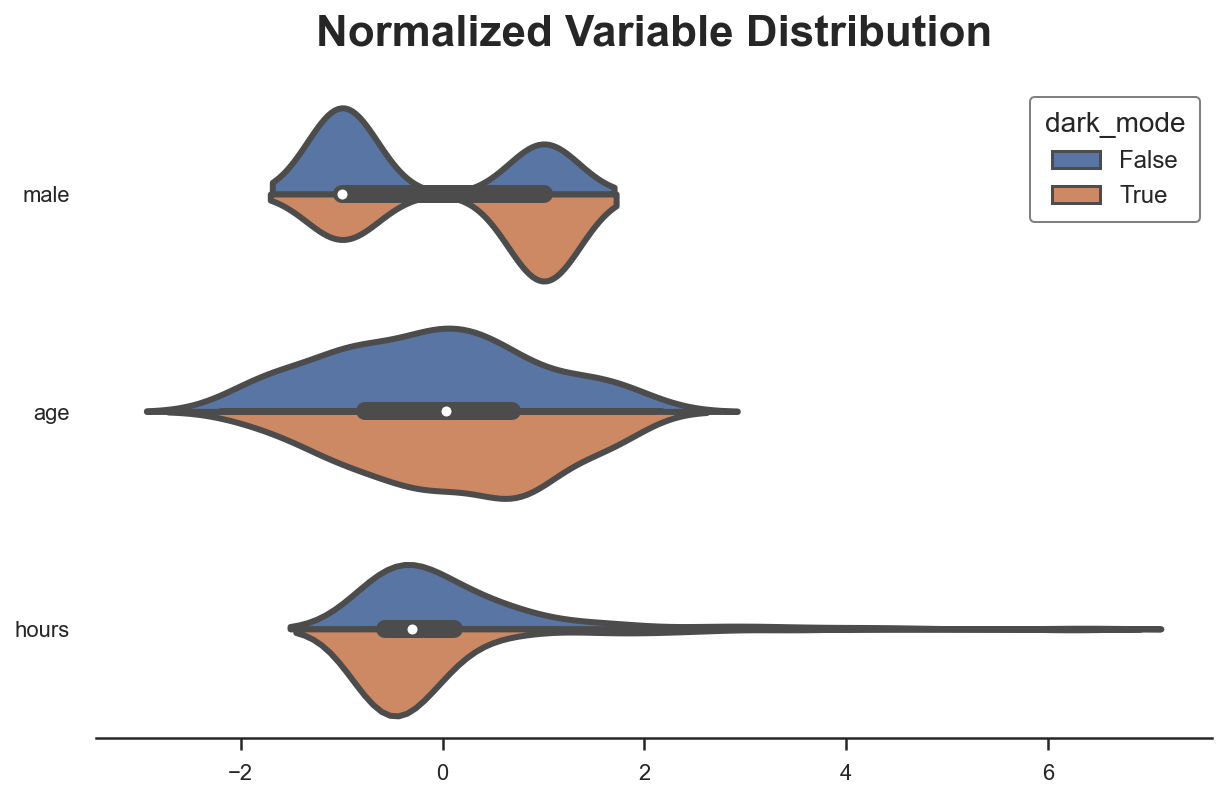

In [7]:
plot_distributions(df, X, "dark_mode")

The insight of the violinplot is very similar: it seems that users that select the `dark_mode` are different from users that don't.

**Why do we care?**

If we do not control for the observable characteristics, we are unable to estimate the true treatment effect. In short, we cannot be certain that the difference in outcome, `read_time`, can be attributed to the treatment, `dark_mode`, instead of other characteristics. For example, it could be that males read more and also prefer the `dark_mode`, therefore we observe a positive correlation even though `dark_mode` has no effect on `read_time`.

In terms of Dyrected Acyclic Graphs, this means that we have several [**backdoor path**](https://towardsdatascience.com/b63dc69e3d8c) that we need to **block** in order for our analysis to be **causal**. 

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 --> Y
X1 --> D
X2 --> D
X2 --> Y
X3 --> D
X3 --> Y

linkStyle 0 stroke:#00ff00,stroke-width:4px;
linkStyle 1,2,3,4,5,6 stroke:#ff0000,stroke-width:4px;
class D,Y included;
class X1,X2,X3 excluded;
```

How do we **block backdoor paths**? By conditioning the analysis on those intermediate variables. The conditional analysis allows us to recover the average treatment effect of the `dark_mode` on `read_time`.

```mermaid
flowchart TB
classDef included fill:#DCDCDC,stroke:#000000,stroke-width:2px;
classDef excluded fill:#ffffff,stroke:#000000,stroke-width:2px;
classDef unobserved fill:#ffffff,stroke:#000000,stroke-width:2px,stroke-dasharray: 5 5;

X1((gender))
X2((age))
X3((hours))
D((dark mode))
Y((read time))

D --> Y
X1 -.-> Y
X1 -.-> D
X2 -.-> D
X2 -.-> Y
X3 -.-> D
X3 -.-> Y

linkStyle 0 stroke:#00ff00,stroke-width:4px;
class D,Y,X1,X2,X3 included;
```

How do we **condition the analysis** on `gender`, `age` and `hours`? We have some options:

- **Matching**
- **Propensity score** weighting
- **Regression** with control variables

Let's explore and compare them!

## Conditional Analysis

We assume that for a set of subjects $i = 1, ..., n$ we observed a tuple $(D_i, Y_i, X_i)$ comprised of 


- a treatment assignment $D_i \in \lbrace 0, 1 \rbrace$ (`dark_mode`)
- a response $Y_i \in \mathbb R$ (`read_time`)
- a feature vector $X_i \in \mathbb R^n$ (`gender`, `age` and `hours`)

**Assumption 1 : unconfoundedness** (or ignorability, or selection on observables)

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ D_i \ | \ X_i
$$

i.e. conditional on observable characteristics $X$, the treatment assignment $D$ is as good as random. What we are effectively assuming is that there is no other characteristics that we do not observe that could impact both whether a user selects the `dark_mode` and their `read_time`.

**Assumption 2: overlap** (or bounded support)

$$
\exists \eta > 0 \ : \ \eta \leq \mathbb E \left[ T_i = 1 \ \big | \ X_i = x \right] \leq 1-\eta
$$

i.e. no observation is deterministically assigned to the treatment or control group. This is a more technical assumption that basically means that for any level of `gender`, `age` or `hours`, there could exist an individual that select the `dark_mode` and one that doesn't.

### Matching

The first and most intuitive method to perform **conditional analysis** is matching. 

The idea of matching is very simple. Since we are not sure whether, for example, male and female users are directly comparable, we do the analysis within gender. Instead of comparing `read_time` across `dark_mode` in the whole sample, we do it separately for male and female users.

In [8]:
df_gender = pd.pivot_table(df, values='read_time', index='male', columns='dark_mode', aggfunc=np.mean)
df_gender['diff'] = df_gender[1] - df_gender[0] 
df_gender

dark_mode,False,True,diff
male,,,
0,17.856857,19.241739,1.384882
1,13.291148,12.491591,-0.799557


Now the effect of `dark_mode` seems reversed: it is negative for male users (-0.79) but bigger and positive for female users (+1.38), suggesting a positive aggregate effect, 1.38 - 0.79 = 0.59 (assuming equal proportion of genders)!

This comparison was easy for `gender` since it is a binary variable. With multiple variables, potentially continuous, matching becomes much more difficult. One common strategy is to **match users** in the treatment group with the most similar user in the control group, using some sort of [nearest neighbor algorithm](https://en.wikipedia.org/wiki/Nearest_neighbour_algorithm). I won't go into the algorithm details here, but we can perform the matching with the `NearestNeighborMatch` function from the `causalml` package. 

The `NearestNeighborMatch` function generates a new dataset where users in the treatment group have been matched 1:1 (option `ratio=1`) to users in the control group.

In [9]:
from causalml.match import NearestNeighborMatch

psm = NearestNeighborMatch(replace=True, ratio=1, random_state=1)
df_matched = psm.match(data=df, treatment_col="dark_mode", score_cols=X)

Are the two groups more comparable now? We can produce a new version of the **balance table**.

In [10]:
table1_matched = create_table_one(df_matched, "dark_mode", X)
table1_matched

,Control,Treatment,SMD
Variable,,,
n,123,123,
age,43.89 (10.38),43.94 (10.40),0.0047
hours,158.59 (154.46),152.27 (154.70),-0.0408
male,0.65 (0.48),0.65 (0.48),0.0


Now the average differences between the two groups have shrunk by at least a couple of orders of magnitude. We can visually inspect distributional differences with the paired violinplot.

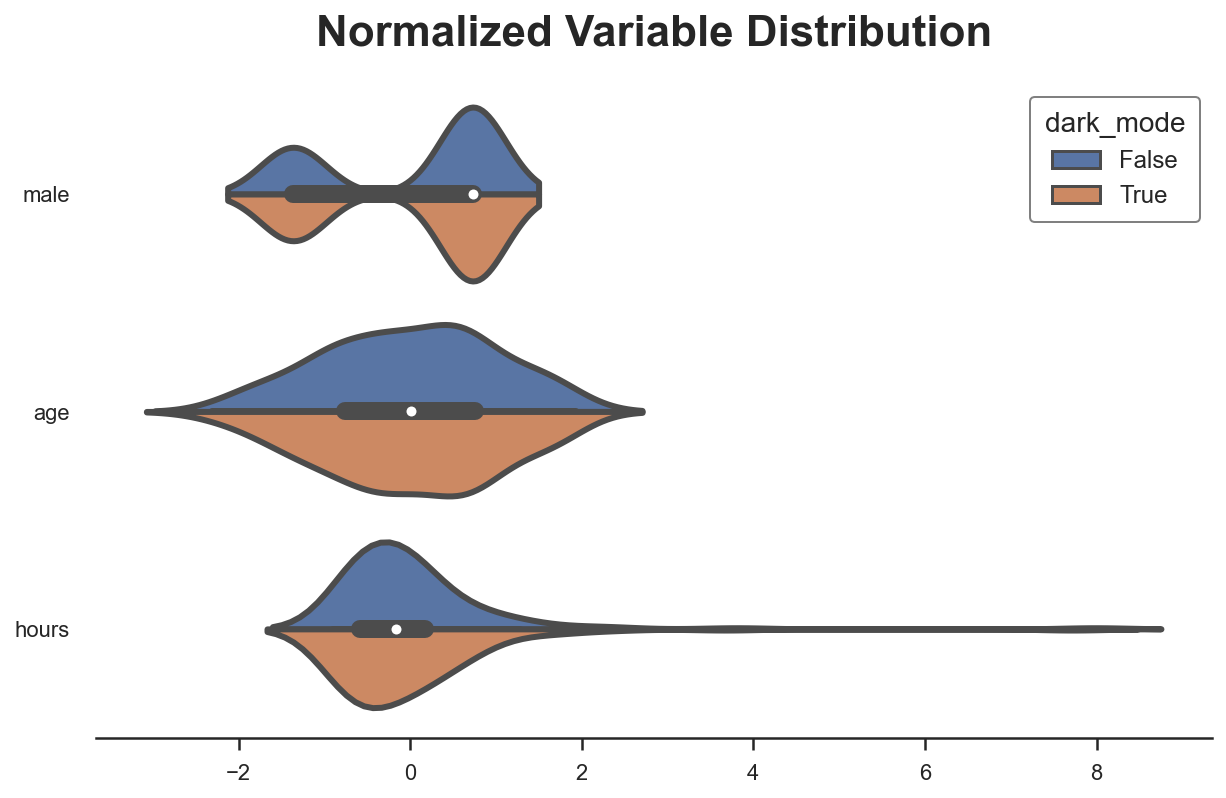

In [11]:
plot_distributions(df_matched, X, "dark_mode")

A popular way to visualize pre- and post-matching covariate balance is the **balance plot** that essentially displays the standardized mean differences before and after matching, for each control variable.

In [12]:
def plot_balance(t1, t2, X):
    df_smd = pd.DataFrame({"Variable": X + X,
                           "Sample": ["Unadjusted" for _ in range(len(X))] + ["Adjusted" for _ in range(len(X))],
                           "Standardized Mean Difference": t1["SMD"][1:].to_list() + 
                                                           t2["SMD"][1:].to_list()})

    sns.scatterplot(x="Standardized Mean Difference", y="Variable", hue="Sample", data=df_smd).\
        set(title="Balance Plot")
    plt.axvline(x=0, color='k', ls='--', zorder=-1, alpha=0.3);

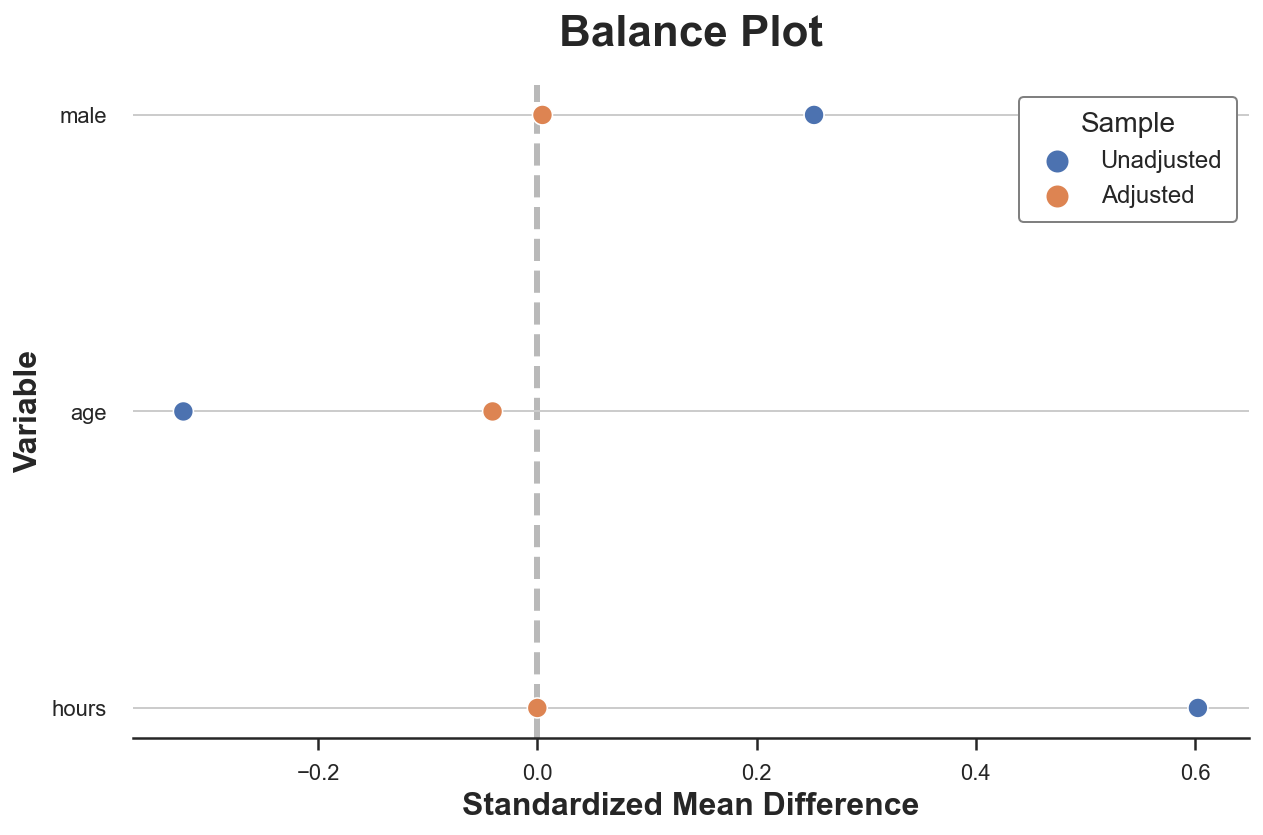

In [13]:
plot_balance(table1, table1_matched, X)

As we can see, now all differences in observable characteristics between the two groups are essentially zero. We could also compare the distributions using other metrics or test statistics, such as the [Kolmogorov-Smirnov test statistic](https://towardsdatascience.com/9b06ee4d30bf).

How do we **estimate the average treatment effect**? We can simply do a difference in means. An equivalent way that automatically provides standard errors is to run a linear regression of the outcome, `read_time`, on the treatment, `dark_mode`. 

In [14]:
smf.ols("read_time ~ dark_mode", data=df_matched).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,13.4627,0.513,26.262,0.000,12.453,14.472
dark_mode[T.True],0.9148,0.725,1.262,0.208,-0.513,2.343


The effect is now positive, but not statistically significant.

### Propensity Score

[Rosenbaum and Rubin (1983)](https://academic.oup.com/biomet/article/70/1/41/240879) prove a very powerful result: if the **strong ingorability assumption** holds, it is sufficient to condition your analysis on the probability ot treatment, the **propensity score**, in order to obtain conditional independence.

$$
\big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ D_i \ | \ X_i \quad \leftrightarrow \quad \big \lbrace Y_i^{(1)} , Y_i^{(0)} \big \rbrace \ \perp \ D_i \ | \ e(X_i)
$$

Where $e(X_i)$ is the probability of treatment of individual $i$, given the observable characteristics $X$, 

$$
e(x) = \mathbb P \left[ D_i = 1 \ \big | \ X_i = x \right]
$$

This is an incredibly **powerful and practical result** since the propensity score is a **one dimensional** variable, while $X$ might be very high dimensional. 

Under **unconfoundedness** assumption introduced above, we can rewrite the average treatment effect as

$$
\tau(x) = \mathbb E \left[ Y^{(1)} - Y^{(0)} \ \big| \ X = x \right] = \mathbb E \left[ \frac{D_i Y_i}{e(X_i)} - \frac{(1-D_i) Y_i}{1-e(X_i)} \right]
$$

Note that this formulation of the average treatment effect does not depend on the potential outcomes $Y_i^{(1)}$ and $Y_i^{(0)}$, but only on the observed outcomes $Y_i$.

This formulation of the average treatment effect implies the **Inverse Propensity Weighted (IPW)** estimator which is an unbiased estimator for the average treatment effect $\tau$ 

$$
\hat \tau^{*}_{IPW} = \frac{1}{n} \sum _ {i=1}^{n} \left( \frac{D_i Y_i}{e(X_i)} - \frac{(1-D_i) Y_i}{1-e(X_i)} \right)
$$

However, this estimator is **unfeasible** since we do not observe the propensity scores $e(X_i)$. However, we can estimate it. Actually, [Imbens, Hirano, Ridder (2003)](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00442) show that you **should** use the estimated propensity score even if we knew the true values (for example because you know the sampling procedure). The idea is that if the estimated propensity scores are different from the true ones, this can be informative in the estimation.

There are several possible ways to estimate a probability, the simplest and most common one is [**logistic regression**](https://en.wikipedia.org/wiki/Logistic_regression).

In [15]:
df["pscore"] = smf.logit("np.rint(dark_mode) ~ male + age + hours", data=df).fit(disp=False).predict()

An **important check** to perform after estimating propensity scores is plotting them, across treatment and control groups. First of all, we can then observe whether the two groups are balanced or not, depending on how close the two distributions are. Moreover, we can also check how likely it is that the **overlap assumption** is satisfied. Ideally both distributions should span the same interval.

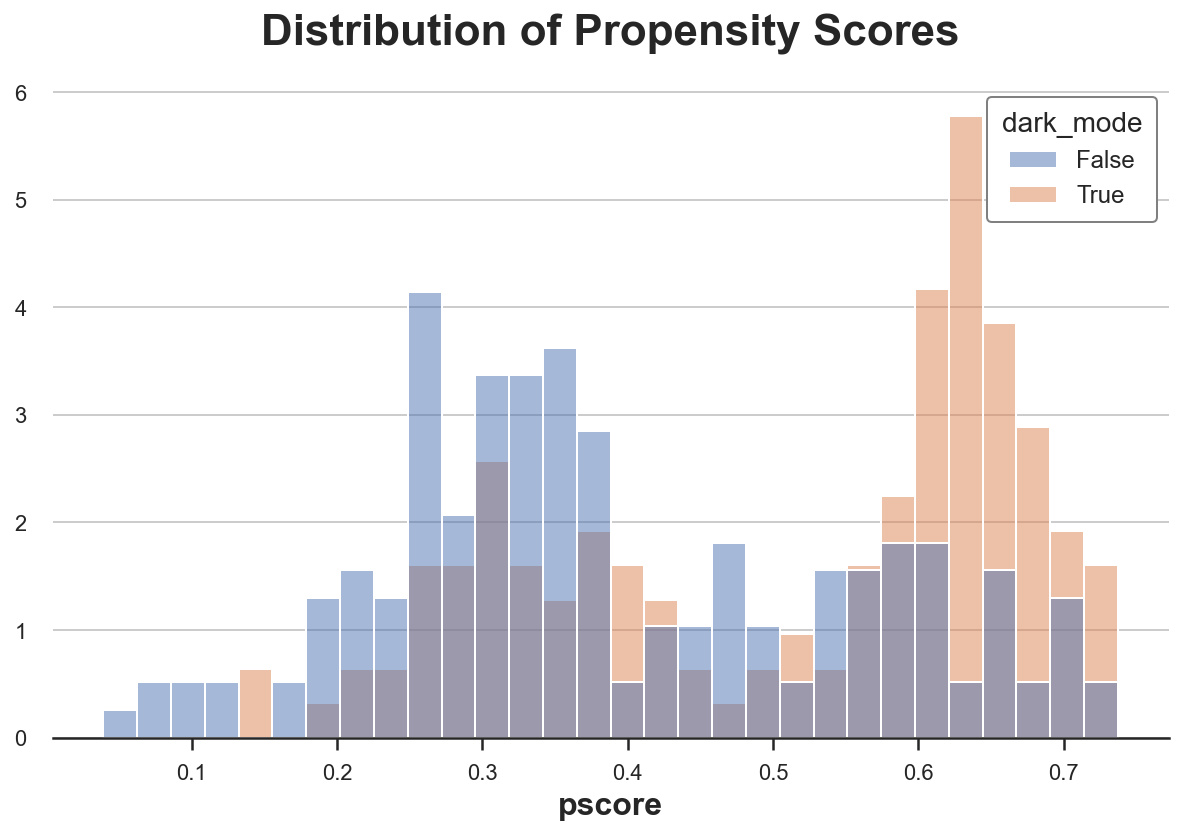

In [16]:
sns.histplot(data=df, x='pscore', hue='dark_mode', bins=30, stat='density', common_norm=False).\
    set(ylabel="", title="Distribution of Propensity Scores");

As expected, the distribution of propensity scores between the treatment and control group is **significantly different**, suggesting that the two groups are hardly comparable. Moreover, there is significant overlap in the support of the distributions, suggesting that the overlap assumption is likely to be satisfied.

Howe do we estimate the average treatment effect?

Once we have computed the propensity scores, we just need to re-weight observations by their respective propensity score. We can then either compute a difference between the weighted `read_time` averages, or run a weighted regression of `read_time` on `dark_mode`.

In [17]:
w = 1 / (df["pscore"] * df["dark_mode"] + (1-df["pscore"]) * (1-df["dark_mode"]))
smf.wls("read_time ~ dark_mode", weights=w, data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,15.0908,0.501,30.132,0.000,14.105,16.076
dark_mode[T.True],1.5609,0.707,2.208,0.028,0.170,2.952


The effect of the `dark_mode` is now positive and statistically significant, at the 5% level!

### Regression with Control Variables

The last method we are going to review today is **linear regression with control variables**. This estimator is extremely easy to implement, since we just need to add the user characteristics - `gender`, `age` and `hours` - to the regression of `read_time` on `dark_mode`.

In [18]:
smf.ols("read_time ~ dark_mode + male + age + hours", data=df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.1829,1.048,18.299,0.000,17.120,21.246
dark_mode[T.True],1.4987,0.541,2.769,0.006,0.434,2.564
male,-5.6579,0.529,-10.704,0.000,-6.698,-4.618
age,-0.0944,0.023,-4.149,0.000,-0.139,-0.050
hours,0.0098,0.001,11.911,0.000,0.008,0.011


The average treatment effect is again positive and statistically significant at the 1% level!

## Comparison

How do the different methods compare to each other?

There is a tight connection between the **IPW** estimator and linear regression with covariates. This is particularly evident when we have a single, binary covariate $X$.

In this case, the estimand of IPW (i.e. the quantity that IPW estimates) is given by

$$
\beta^{IPW} = \frac{ \sum_x \color{red}{\beta_x} \color{blue}{\Pr(D_i | X_i = x)} \Pr(X_i = x)}{\sum_x \color{blue}{\Pr(D_i | X_i = x)} \Pr(X_i = x)}
$$

The IPW estimand is a weighted average of the treatment effects $\beta_x$, where the weights are given by the **treatment probabilities**.

On the other hand, the estimand of linear regression with control variables is

$$
\beta^{OLS} = \frac{ \sum_x \color{red}{\beta_x} \color{blue}{\Pr(D_i | X_i = x)(1 - \Pr(D_i | X_i = x)) } \Pr(X_i = x)}{\sum_x \color{blue}{\Pr(D_i | X_i = x)(1 - \Pr(D_i | X_i = x)) } \Pr(X_i = x)}
$$

The OLS estimand is a weighted average of the treatment effects $\beta_x$, where the weights are given by the **variance of the treatment probabilities**. This means that linear regression is a weighted estimator, that gives more weight to observations that have characteristics for which we observe more treatment variability. Since a binary random variable has the highest variance when its expected value is 0.5, **OLS gives the most weight to observations that have characteristics for which we observe 50/50 split between treatment and control group**. On the other hand, if for some characteristics we only observe treated or untreated individuals, those are going to receive zero weight. I recommend Chapter 3 of [Angrist and Pischke (2009)](https://www.mostlyharmlesseconometrics.com/) for more details.

## Conclusion

Last but not least, if you want to know more, I strongly recommend this **video lecture** on propensity scores from [Paul Goldsmith-Pinkham](https://paulgp.github.io/) that is freely available online.

<br>

{{< youtube 8gWctYvRzk4 >}}

<br>

The whole course is a gem and it is an incredible privilege to have such high quality material available online for free.

### References

[1] P. Rosenbaum, D. Rubin, [The central role of the propensity score in observational studies for causal effects](https://academic.oup.com/biomet/article/70/1/41/240879) (1983), *Biometrika*.

[2] G. Imbens, K. Hirano, G. Ridder, [Efficient Estimation of Average Treatment Effects Using the Estimated Propensity Score](https://onlinelibrary.wiley.com/doi/abs/10.1111/1468-0262.00442) (2003), *Econometrica*.

[3] J. Angrist, J. S. Pischke, [Mostly harmless econometrics: An Empiricist's Companion](https://www.mostlyharmlesseconometrics.com/) (2009), *Princeton University Press*.

### Related Articles

- [Understanding The Frisch-Waugh-Lovell Theorem](https://towardsdatascience.com/59f801eb3299)
- [How to Compare Two or More Distributions](https://towardsdatascience.com/9b06ee4d30bf)
- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/ipw.ipynb